## 1. Import Library and Dataset

In [1]:
import os
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dropout

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rendychristian","key":"ba4667e0c52e4c2124c2d1455ebffcd5"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! kaggle datasets download -d grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

## 2. Data Preprocessing

In [6]:
# Remove 'del', 'nothing', and 'space' folder
import shutil
import os
TRAIN_DIR = os.path.join("asl_alphabet_train", "asl_alphabet_train")
folders_to_remove = ['del', 'nothing', 'space']
# Loop every folder and remove them
for folder in folders_to_remove:
    folder_path = os.path.join(TRAIN_DIR, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)  # Remove folder, including the contents

IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32
CLASSES = os.listdir(TRAIN_DIR)
NUM_CLASSES = len(CLASSES)
print(CLASSES)
print(NUM_CLASSES)

SEED = 17

['Z', 'O', 'W', 'U', 'J', 'H', 'I', 'T', 'G', 'M', 'D', 'R', 'Q', 'K', 'P', 'C', 'S', 'V', 'A', 'Y', 'X', 'F', 'E', 'L', 'B', 'N']
26


In [7]:
# Reduce files from dataset
import os
import random
import shutil

folders_to_reduce = os.listdir(TRAIN_DIR)
target_file_count = 300

# Loop every folder and reduce the files to 300
for folder in folders_to_reduce:
    folder_path = os.path.join(TRAIN_DIR, folder)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        if len(files) > target_file_count:
            # Take random files
            files_to_keep = random.sample(files, target_file_count)
            # Remove untaken files
            for file in files:
                if file not in files_to_keep:
                    os.remove(os.path.join(folder_path, file))

In [8]:
# Load dataset from directory, split dataset
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 7800 files belonging to 26 classes.
Using 6240 files for training.
Found 7800 files belonging to 26 classes.
Using 1560 files for validation.


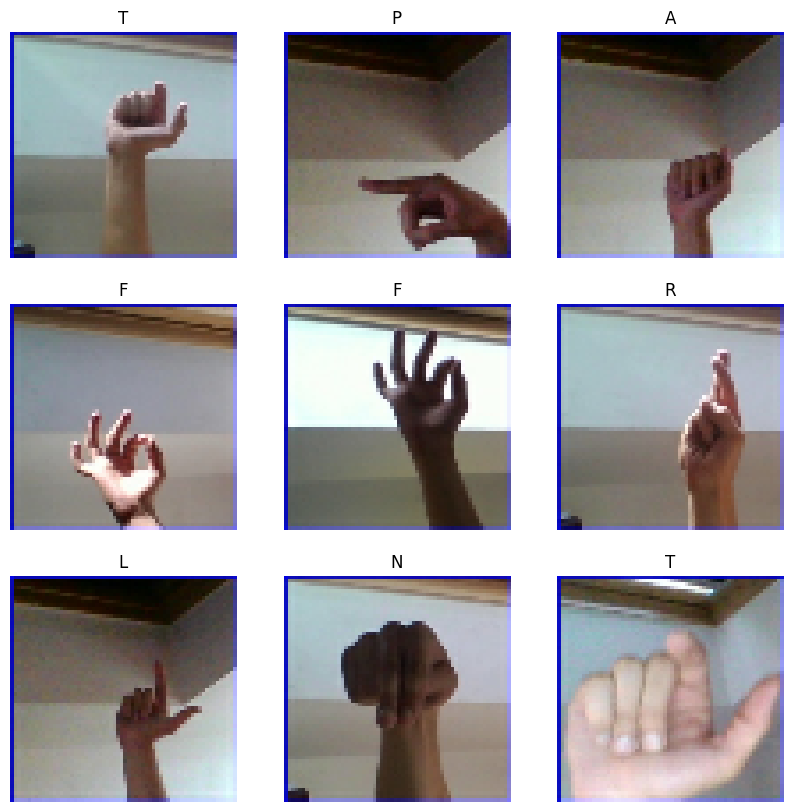

In [9]:
# Plot random image from dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [10]:
# Data Augmentation (image rescaling)

normalize = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalize(x), y))
val_ds = val_ds.map(lambda x, y: (normalize(x), y))

## 3. Generate CNN Model

In [11]:
# Generate CNN Model

inputs = Input(shape=IMAGE_SIZE+(3,), batch_size=BATCH_SIZE)
# Convolutional Base
x = Conv2D(64, kernel_size=3, padding="same", activation="relu")(inputs)
x = MaxPooling2D(2)(x)
x = Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)
x = Conv2D(256, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)

# Head (Classifier)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=x, name="ASL_CNN")

In [12]:
# Detail information of the model
model.summary()

Model: "ASL_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv2d (Conv2D)             (32, 64, 64, 64)          1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 32, 32, 64)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 32, 32, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 16, 16, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 16, 16, 256)         2951

In [13]:
# Define model optimizer and cronssentropy
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

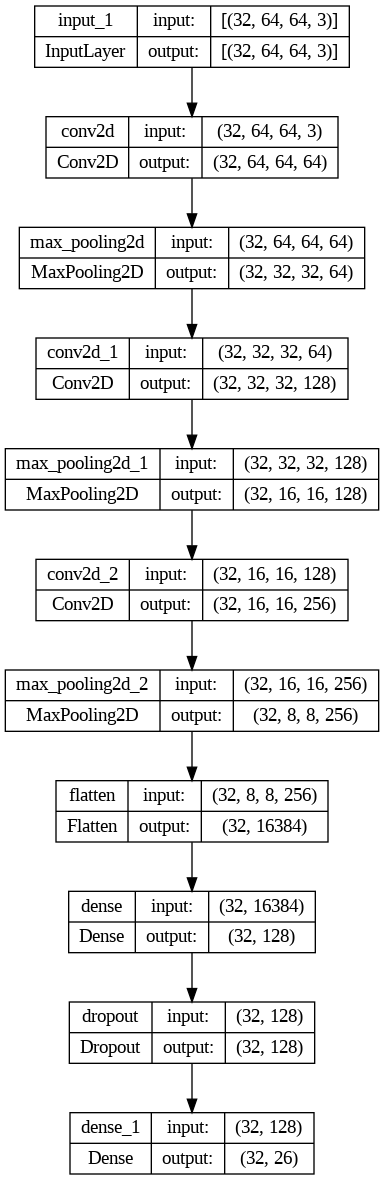

In [14]:
# Detail information of the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
# Model Training

epochs = 25

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Epoch 1/25
195/195 [==============================] - 185s 941ms/step - loss: 3.0800 - accuracy: 0.1050 - val_loss: 2.5311 - val_accuracy: 0.3115
Epoch 2/25
195/195 [==============================] - 167s 853ms/step - loss: 2.1491 - accuracy: 0.3252 - val_loss: 1.3628 - val_accuracy: 0.5987
Epoch 3/25
195/195 [==============================] - 162s 833ms/step - loss: 1.4203 - accuracy: 0.5234 - val_loss: 0.8496 - val_accuracy: 0.7487
Epoch 4/25
195/195 [==============================] - 181s 927ms/step - loss: 0.9911 - accuracy: 0.6699 - val_loss: 0.6520 - val_accuracy: 0.7994
Epoch 5/25
195/195 [==============================] - 168s 863ms/step - loss: 0.7705 - accuracy: 0.7329 - val_loss: 0.5164 - val_accuracy: 0.8308
Epoch 6/25
195/195 [==============================] - 173s 889ms/step - loss: 0.5987 - accuracy: 0.8008 - val_loss: 0.3937 - val_accuracy: 0.8769
Epoch 7/25
195/195 [==============================] - 178s 913ms/step - loss: 0.4995 - accuracy: 0.8287 - val_loss: 0.2957 -

## 4. Save Model

In [17]:
# Save model to local for further process (.hdf5 format)
model.save("cnn_model_25b.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Save model to local for further process (.h5 format)
model.save("cnn_model_25b.h5")

## 5. Evaluate Model

<Axes: >

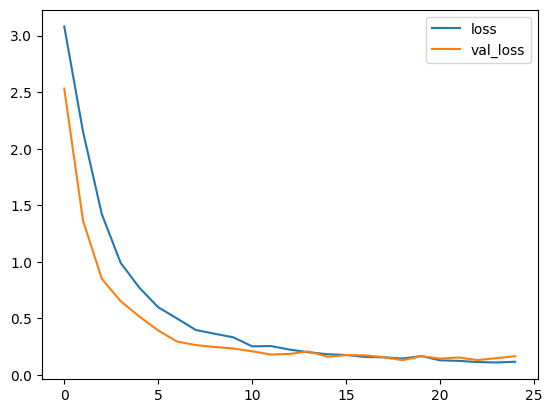

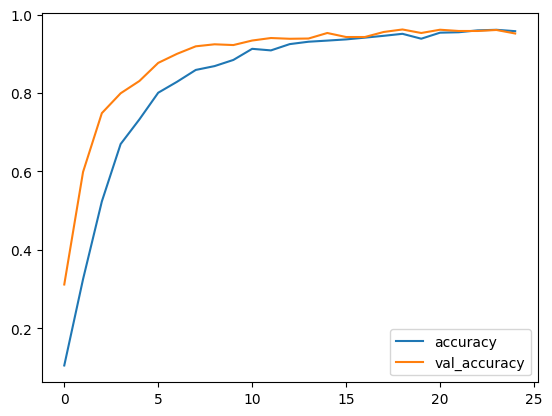

In [16]:
# Plot loss comparison of train_loss vs val_loss from model training history
df = pd.DataFrame(history.history)
df.loc[:, ["loss", "val_loss"]].plot()
# Plot accuracy comparison of train_accuracy vs val_accuracy from model training history
df.loc[:, ["accuracy", "val_accuracy"]].plot()

In [23]:
# Display prediction from trained model

TEST_DIR = 'asl_alphabet_test/asl_alphabet_test'
LIST_DIR = os.listdir(TEST_DIR)
LIST_DIR

import os
import tensorflow as tf
from PIL import Image
import numpy as np

# Load your trained model
model = tf.keras.models.load_model('cnn_model_25b.h5')

# Define preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((64, 64))  # Adjust to your model's input size
    image = np.array(image) / 255.0  # Normalize pixel values
    return image

# List of test images
test_image_folder = 'asl_alphabet_test/asl_alphabet_test/'
test_images = [file for file in os.listdir(test_image_folder) if file.endswith('.jpg')]

# Make predictions for each test image
for image_file in test_images:
    image_path = os.path.join(test_image_folder, image_file)
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))
    predicted_class = np.argmax(prediction)  # Assuming your model outputs class probabilities
    print(f"Predicted class for {image_file}: {predicted_class}")


1/1 [==============================] - 0s 138ms/step
Predicted class for K_test.jpg: 10
1/1 [==============================] - 0s 43ms/step
Predicted class for Y_test.jpg: 24
1/1 [==============================] - 0s 45ms/step
Predicted class for Z_test.jpg: 25
1/1 [==============================] - 0s 51ms/step
Predicted class for Q_test.jpg: 16
1/1 [==============================] - 0s 46ms/step
Predicted class for X_test.jpg: 23
1/1 [==============================] - 0s 48ms/step
Predicted class for U_test.jpg: 20
1/1 [==============================] - 0s 41ms/step
Predicted class for M_test.jpg: 12
1/1 [==============================] - 0s 47ms/step
Predicted class for H_test.jpg: 7
1/1 [==============================] - 0s 45ms/step
Predicted class for T_test.jpg: 19
1/1 [==============================] - 0s 60ms/step
Predicted class for V_test.jpg: 21
1/1 [==============================] - 0s 42ms/step
Predicted class for J_test.jpg: 9
1/1 [==============================] - 0s 49

In [24]:
# Display evaluation metrics & confusion matrix

import os
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load trained model
model = tf.keras.models.load_model('cnn_model_25b.h5')

# Define preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((64, 64))
    image = np.array(image) / 255.0
    return image

# List of test images and true labels
test_image_folder = 'asl_alphabet_test/asl_alphabet_test/'
test_images = [file for file in os.listdir(test_image_folder) if file.endswith('.jpg')]
true_labels = [ord(filename.split('_')[0]) - ord('A') for filename in test_images]  # Convert alphabet label to numerical label

# Make predictions for each test image
predicted_labels = []
for image_file in test_images:
    image_path = os.path.join(test_image_folder, image_file)
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))
    predicted_class = np.argmax(prediction)
    predicted_labels.append(predicted_class)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


1/1 [==============================] - 0s 28ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 

1/1 [==============================] - 0s 28ms/step


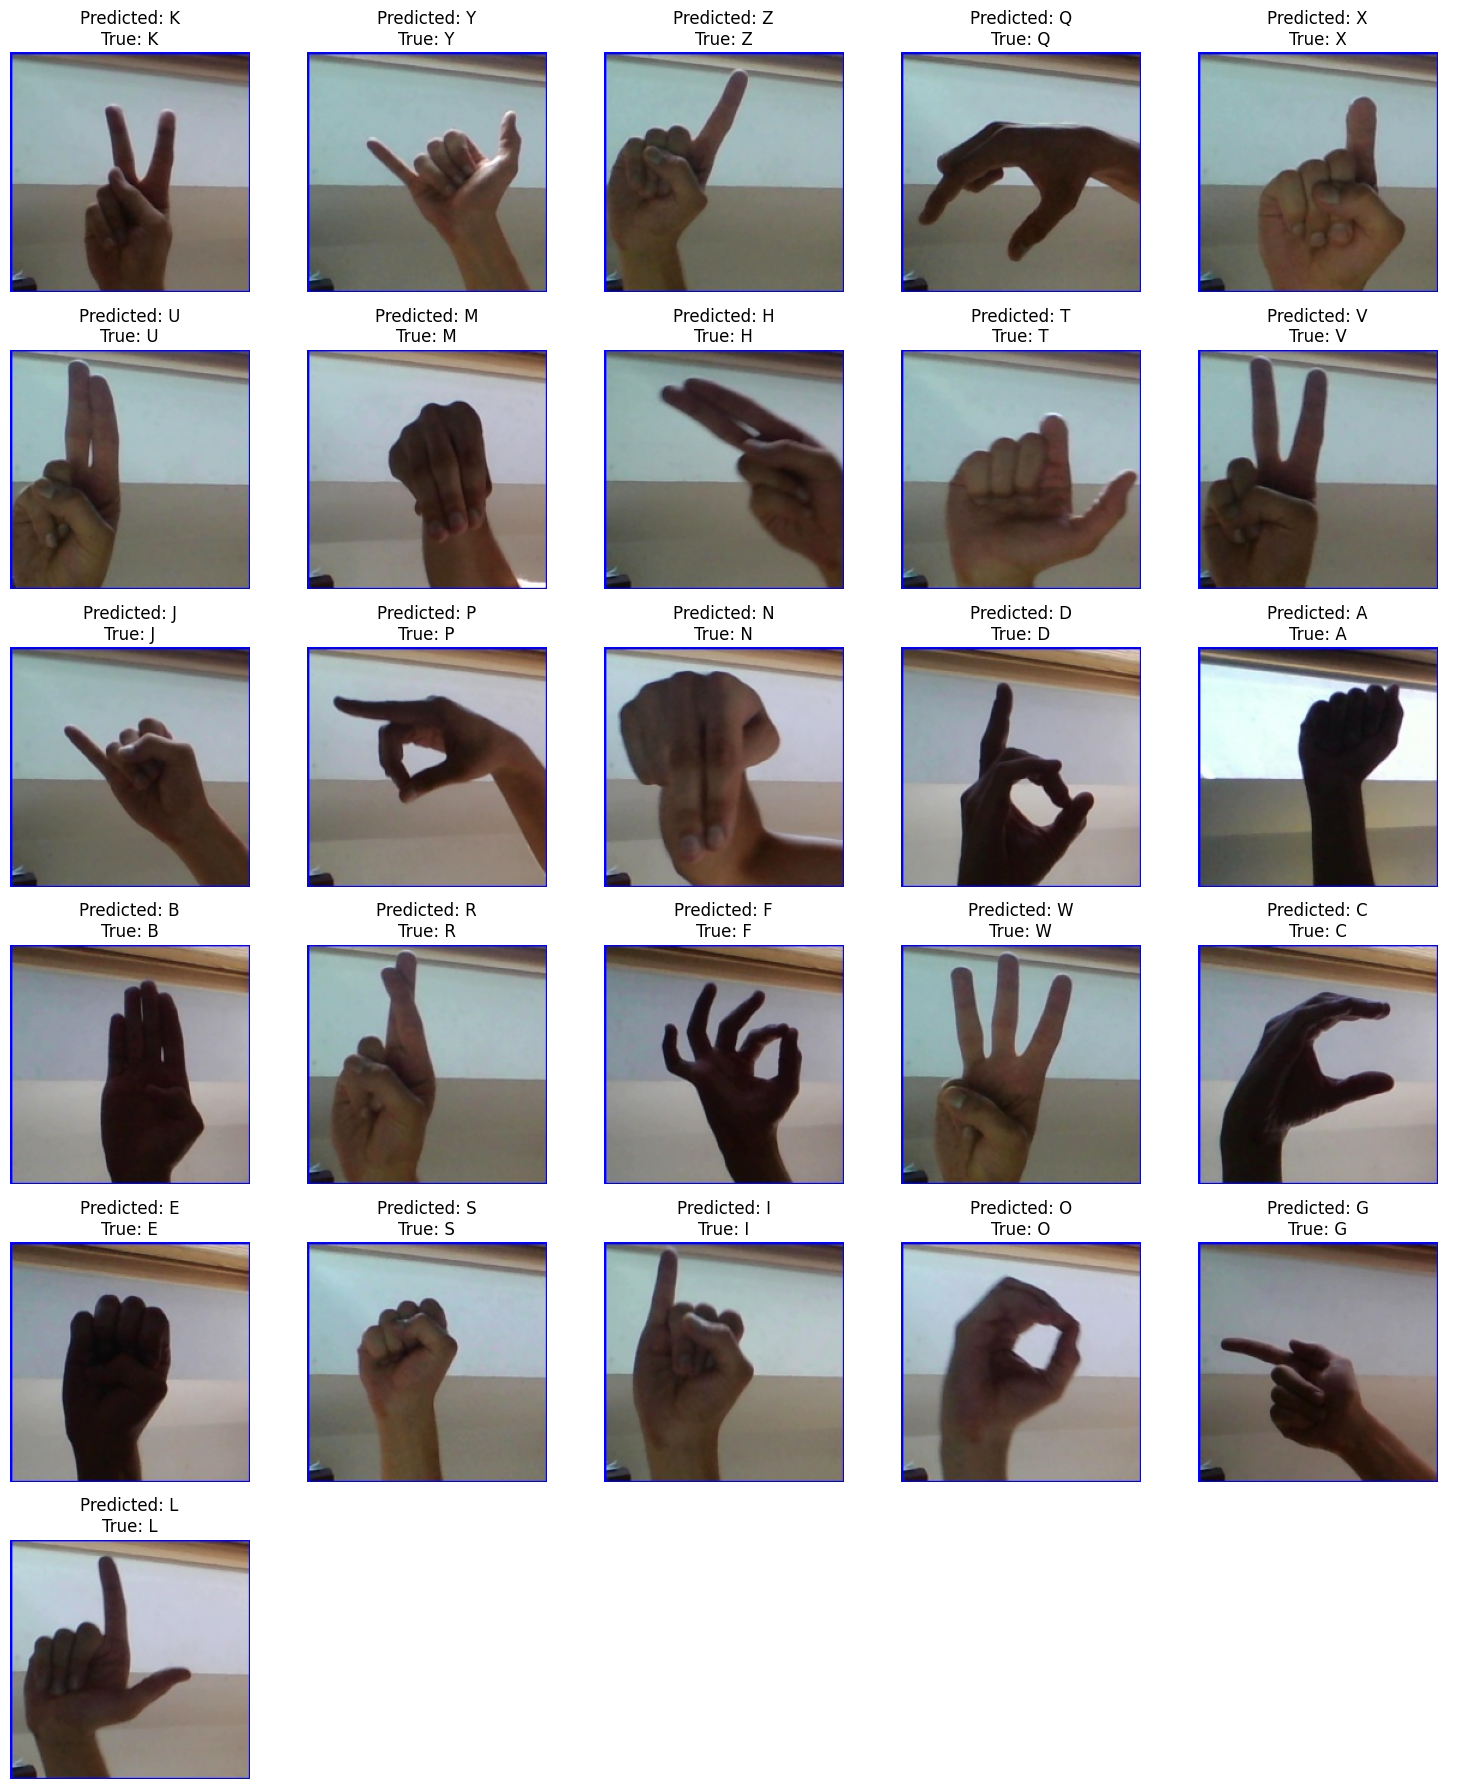

In [39]:
# Display evaluation metrics & confusion matrix

import os
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load trained model
model = tf.keras.models.load_model('cnn_model_25b.h5')

# Define preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((64, 64))
    image = np.array(image) / 255.0
    return image

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# List of test images and true labels
test_image_folder = 'asl_alphabet_test/asl_alphabet_test/'
test_images = [file for file in os.listdir(test_image_folder) if file.endswith('.jpg')]
true_labels = [ord(filename.split('_')[0]) - ord('A') for filename in test_images]  # Convert alphabet label to numerical label

num_images = len(test_images)
num_cols = 5
num_rows = (num_images // num_cols) + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
for i, image_name in enumerate(test_images):
    # Baca dan preprocessing gambar
    image_path = os.path.join(test_image_folder, image_name)
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)

    # Prediksi kelas
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    predicted_letter = alphabet[predicted_class]

    # Tampilkan gambar dan hasil prediksi
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(plt.imread(image_path))
    ax.set_title(f'Predicted: {predicted_letter}\nTrue: {alphabet[true_labels[i]]}')
    ax.axis('off')

# Hapus subplot yang tidak terpakai
for i in range(num_images, num_rows * num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()
